In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
import pandas as pd
import pylab as plt
import pystan
import seaborn as sns
import numpy as np
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

![](../../assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->

<http://www.DataJavelin.com>
## Dr Peter Hurley 

# Bayesian Data Analysis Workflow with Stan

A good workflow for developing and testing models is essential!

1. Model Building
2. Model Inference
3. Model Checking
4. Model Improvment

For more detailed information see [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) book by Andrew Gelman and co-authors and [Michael Betancourt's case study](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#1_bayesian_modeling_and_inference)

Lets go through steps with an example problem

## Golf putting
An example from [Andrew Gelman's blog](https://statmodeling.stat.columbia.edu/2019/03/21/new-golf-putting-data-and-a-new-golf-putting-model/)

In [3]:
data=pd.read_csv('../../orig_golf_data.txt',sep='\s+')
data

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149
5,7,256,136
6,8,240,111
7,9,217,69
8,10,200,67
9,11,237,75


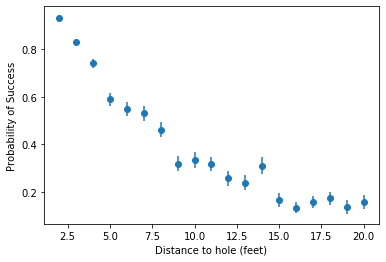

In [6]:
p=data['y']/data['n']
error=np.sqrt(p*(1-p)/data['n'])
plt.errorbar(data['x'],data['y']/data['n'],yerr=error,fmt='o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

With error bars taken as simple classical standard deviations $\sqrt{\hat{p}_j(1-\hat{p}_j)/n_j}$ where $\hat{p}_j=y_j/n_j$ success rate for putts taken at distance $x_j$.

## Model Building


### Build generative model
1. construct a probabilistic generative model of the observation process. 
2. generative observation model can be a crude approximation to the complexity of the true measurement process


An ideal generative model will use mathematical functions to describe how an observation is produced based on a given model configuration. It is described as generative as it models how the data was generated (i.e. joint distribution)

Simple approximations are often good enough to answer even sophisticated questions. We describe the model as generative as we are trying to build a model that replicates how the data was generated. 

Often it is helpful to visualise the model via a probabilistic graphical model. These visualisations are a good way of understanding and showing how different variables relate and depend on each other.

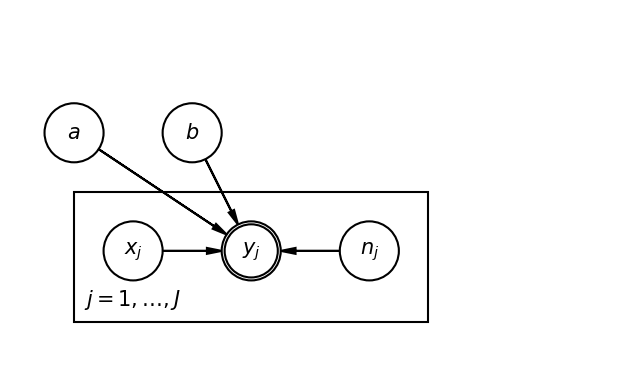

In [7]:
import daft
pgm = daft.PGM(shape=(5,3),observed_style="inner",dpi=150)

# Hierarchical parameters.
pgm.add_node("a", r"$a$", 0.5, 2)
pgm.add_node("b", r"$b$", 1.5, 2)

# Latent variable.
pgm.add_node("x", r"$x_j$", 1, 1)

# Data.
pgm.add_node("y", r"$y_j$", 2, 1, observed=True)
pgm.add_node("n", r"$n_j$", 3, 1)

pgm.add_edge('a','y')
pgm.add_edge('b','y')
pgm.add_edge('x','y')
pgm.add_edge('n','y')

pgm.add_plate([0.5, 0.5, 3, 1], label=r"$j = 1, \ldots, J$", shift=-0.1)

# Render and save.
pgm.render()
pgm.show()

#### Our first model, Logistic regression 
We want to model the probability of success in golf putting as a function of distance from the hole? the natural starting point would be logistic regression:

$$y_j\sim\mbox{binomial}(n_j, \mbox{logit}^{-1}(a + bx_j)),\mbox{ for } j=1,\dots, J.$$

*"the binomial distribution with parameters $n$ and $p$ is the discrete probability distribution of the number of successes in a sequence of n independent experiments."*

This is exactly what we want

#### Logistic regression overview

The Binomial distribution gives us the number of successfull trials from N independent trials, with probability of success $P$. We know:

* $y_j$ the number of successfull putts at distance $x_j$
* $n_j$ the number of putting attempts at distance $x_j$

We don't know $P$. But we know it will change with distance.

*The aim of logistic regression is to predict some unknown probability P for a successful event, for any given linear combination of independent variables (features).*

i.e. $$P=f(x)$$

**Problem**
$$0\le P\le1$$
But in Linear regression, where $y=a+bx$:
$$-\infty \le y \le \infty$$
$$-\infty \le x \le \infty$$

Our function is going to have to do some sort of transformation to map from $[-\infty,\infty]$ to $[0,1]$.





We could try taking the odds ratio, i.e.:
    $$\frac{P}{1-P}$$
but that only gives us:
$$0\le \frac{P}{1-P}\le\infty$$

But if we take the logarithm,i.e.:
    $$\log\frac{P}{1-P}$$
We get:
$$-\infty\le\log\frac{P}{1-P}\le\infty$$

This works. Because the transformation has many uses its been given the name of:

$$\mbox{logit(P)}=\log\frac{P}{1-P}$$

In [8]:
def logit(P):
    return np.log(P/(1-P))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


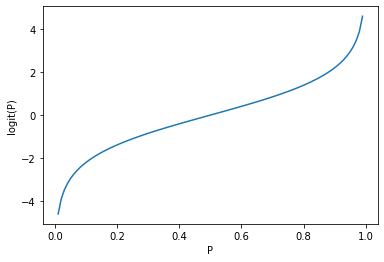

In [9]:
plt.plot(np.arange(0,1,0.01),logit(np.arange(0,1,0.01)))
plt.xlabel('P');
plt.ylabel(r'logit(P)');

#### logit and inverse logit
logit is a link function that can map continuous variables to a range of 0-1. useful when we need a probability output.

combining the $\mbox{logit(P)}$ with the linear regression equations gives us **logisitic regression**

$$\mbox{logit(P)}=y=a+bx$$

we need P, rearrange to get inverse logit function:



In [10]:
def inv_logit(a,b,x):
    return 1/(1+np.exp(-1*(a+b*x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


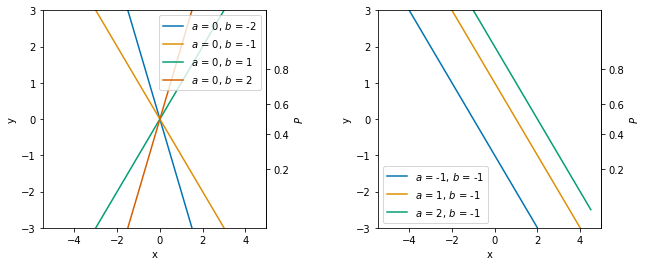

In [11]:
import matplotlib.ticker as ticker

def inv_logit_plot(x):
    return 1/(1+np.exp(-1*(x)))
def logit_plot(x):
    return np.log(x/(1-x))

cmap=sns.color_palette("colorblind")
fig=plt.figure(figsize=(10,4))
x=np.arange(-5,5,0.5)
ax1=fig.add_subplot(1,2,1)
a=0
for i,b in enumerate([-2,-1,1,2]):
    ax1.plot(x,a+b*x,label=r'$a$ = {}, $b$ = {}'.format(a,b),c=cmap[i])

ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylim(-3,3)
secax = ax1.secondary_yaxis('right', functions=(inv_logit_plot, logit_plot))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$P$')




ax3=fig.add_subplot(1,2,2)
b=-1
for i,a in enumerate([-1,1,2]):
    ax3.plot(x,a+b*x,label=r'$a$ = {}, $b$ = {}'.format(a,b),c=cmap[i])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_ylim(-3,3)

secax = ax3.secondary_yaxis('right', functions=(inv_logit_plot, logit_plot))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$P$')

ax3.legend()

plt.subplots_adjust(wspace=0.5)

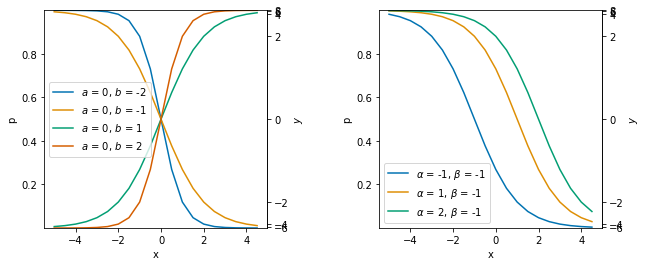

In [12]:
fig=plt.figure(figsize=(10,4))
x=np.arange(-5,5,0.5)
ax1=fig.add_subplot(1,2,1)
a=0
for i,b in enumerate([-2,-1,1,2]):
    plt.plot(x,inv_logit(a,b,x),label=r'$a$ = {}, $b$ = {}'.format(a,b),c=cmap[i])
plt.legend()
plt.xlabel('x')
plt.ylabel('p')

ax1.set_ylim(0.001,0.9999)
secax = ax1.secondary_yaxis('right', functions=(logit_plot,inv_logit_plot))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$y$')

ax3=fig.add_subplot(1,2,2)
b=-1
for i,a in enumerate([-1,1,2]):
    ax3.plot(x,inv_logit(a,b,x),label=r'$\alpha$ = {}, $\beta$ = {}'.format(a,b),c=cmap[i])
ax3.set_xlabel('x')
ax3.set_ylabel('p')
ax3.set_ylim(0.001,0.9999)

secax = ax3.secondary_yaxis('right', functions=(logit_plot,inv_logit_plot ))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$y$')

ax3.legend()

plt.subplots_adjust(wspace=0.5)



Always good to think about problem and put informative priors if possible.

Thinking about our model,
Priors:
* $a$ going to be larger than 0 since we know more than half the putts are made when distance is zero, so put something sensible e.g. 0 to 10
* $b$ has to be negative (probability is not going to increase with distance) it is also going to be larger than -1 since we know the longer distance plots are not impossible

### Writing the model in Stan
* A Stan program is organized into a sequence of named blocks


In [13]:
example_model="""functions {
// ... function declarations and definitions ...
}
data {
// ... declarations ...
}
transformed data {
// ... declarations ... statements ...
}
parameters {
// ... declarations ...
} 
transformed parameters {
// ... declarations ... statements ...}
model {
// ... declarations ... statements ...
}
generated quantities {
// ... declarations ... statements ...
}
"""

### Other things to note:
* Add comments with `\\`
* Sampling statements with `~`
* Can print output with `print()`
* `;` at end of each line


Documentation for Stan: https://mc-stan.org/docs/2_19/stan-users-guide/index.html


In [14]:
golf_model_1="""
data {
  int J;
  int n[J];
  vector[J] x;
  int y[J];
  int fit;           //boolean for fitting
}
parameters {
  real<lower=0,upper=10> a;
  real<lower=-1,upper=0> b;
}
model {
  if (fit>0){
  y ~ binomial_logit(n, a + b*x);
}
}
generated quantities {
int y_pred[J];
for (i in 1:J){
y_pred[i]=binomial_rng(n[i], inv_logit(a + b*x[i]));
}
}
"""

In [15]:
sm=pystan.StanModel(model_code=golf_model_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d53bd31a44b027fe0ac8c6c89a16c2f NOW.


### Analyse the Generative Ensemble
* Analyse a range of samples from generative model
* Check outputs are realistic
* Good way of checking model (especially priors) is behaving appropriately and how you expect

Before drawing inferences from a real observation, we first want to analyse a range of samples from our generative model to check that the resulting putting success relation is realistic. This is a good way of checking that the prior distribution is sensible and the model is behaving approriately.

To do that we first simulate parameters and observations from the complete generative model. We do this with the Python interface to Stan, PyStan.

Simulating from the generative model allows us to see how our model and the prior choices we have made, affect the trend and whether they are realistic or whether we need to go back and rethink the priors. Simulating from the generative model also gives us simulated data for which we know the true parameter values. We can then use this simulated data to carry out the same inference procedures we would run on real data to test whether we can accurately recover the true parameter values. This gives us confidence that when we run it on real data we can trust the parameter values we get.

In [16]:
model_data={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':data['y'],
        'fit':0}


In [17]:
fit=sm.sampling(data=model_data,chains=4,iter=1000,seed=194838)

In [18]:
fit

Inference for Stan model: anon_model_9d53bd31a44b027fe0ac8c6c89a16c2f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            4.99    0.07    2.9   0.26   2.38    5.0   7.51   9.83   1639    1.0
b            -0.5  7.4e-3   0.29  -0.98  -0.76   -0.5  -0.25  -0.03   1519    1.0
y_pred[1]  1244.0   10.21 309.53  373.4 1161.8 1417.0 1441.0 1443.0    920    1.0
y_pred[2]  569.23    5.84 182.06   95.0 501.45  674.0  692.0  694.0    972    1.0
y_pred[3]  352.48    4.26  137.8   30.0  278.0  432.5  453.0  455.0   1045    1.0
y_pred[4]  257.44    3.52 118.02   9.41  171.0  325.0  351.0  353.0   1122    1.0
y_pred[5]  185.31    2.77  98.43    3.0   94.0  240.0 269.55  272.0   1265    1.0
y_pred[6]  162.49    2.66  97.42    1.0   61.0  210.5  252.0  256.0   1340    1.0
y_pred[7]  141.42     2.5  94.85    0.0   34.0  176.5  235.0  240.0   1440 

* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* The amount by which autocorrelation within the chains increases uncertainty in estimates can be measured by effective sample size, $n_{eff}$. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since Stan is efficient, no need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

In [19]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.942) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.04) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.949) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.02) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

*Divergent transitions*:Critical warning. Step size is too large. Try fixing by increasing `adapt_delta` e.g. `fit=sm.sampling(data=data,control=dict(adapt_delta=0.9)`

*Maximum Tree depth*: Not as critical. A detail specific to NUTS algorithm. Fix by increasing tree depth e.g. `fit=sm.sampling(data=data,control=dict(max_treedepth=15)`

*BFMI low*: Bayesian Fraction of Missing Information. Adaptation phase of the Markov Chains did not turn out well and those chains likely did not explore the posterior distribution efficiently. Can try running for more iterations, but probably need to re-parameterise model.


Details on diagnostics are [here](https://mc-stan.org/misc/warnings.html). Good explanation for divergences can also be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762)

Prior distribution on parameters:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


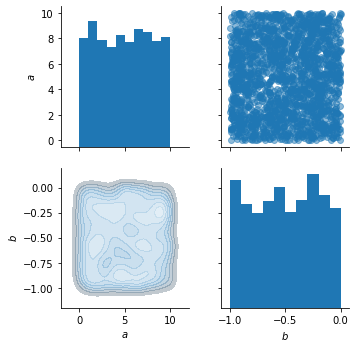

In [20]:
tri=sns.PairGrid(pd.DataFrame(np.vstack((fit['a'],fit['b'])).T,columns=[r'$a$',r'$b$']))
tri.map_diag(plt.hist)
tri.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Blues_d",alpha=0.3,n_levels=10,normed=True)
tri.map_upper(plt.scatter,alpha=0.5)


Lets look at Prior predicitive distribution

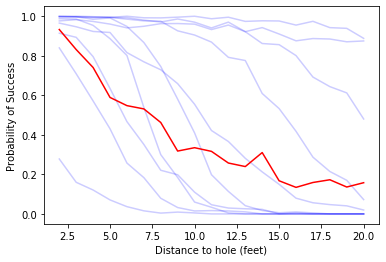

In [21]:

for i in range(0,1000,100):
    plt.plot(data['x'],fit['y_pred'][i,:]/data['n'],'b',alpha=0.2)
plt.plot(data['x'],data['y']/data['n'],'r')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

### Fit the Simulated Observations and Evaluate
* Test ability to fit model (testing fitting algorithms)
* Fit samples from the prior predicitive distribution
* Compare Posterior probabillity distribution with truth


We have generated a sample of simulated observations from our generative model. To test our ability to draw inferences with the model when using real data, we can attempt to fit each of these simulated observations and construct a posterior distribution on the parameters of interest. The advantage of fitting simulated results is we know the truth and so we can compare the posterior probability distributions coming from the inference with the true values. Lets start with fitting one sample from our simulated observations.

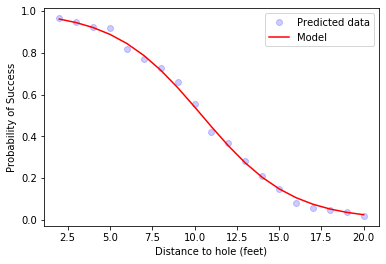

In [36]:
s=800
plt.plot(data['x'],fit['y_pred'][s,:]/data['n'],'bo',alpha=0.2,label='Predicted data')
plt.plot(data['x'],inv_logit(fit['a'][s],fit['b'][s],data['x']),'r',label='Model')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

plt.legend();

In [37]:
print('a =',fit['a'][s])

a = 3.9783182618673516


In [38]:
print('b =',fit['b'][s])

b = -0.3812317529571998


In [39]:
data_samp={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':fit['y_pred'][s,:].astype('int'),
        'fit':1}


In [40]:
fit_samp=sm.sampling(data=data_samp,chains=4,iter=1000,seed=10)

In [41]:
fit_samp

Inference for Stan model: anon_model_9d53bd31a44b027fe0ac8c6c89a16c2f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a             4.1  4.4e-3    0.1   3.91   4.03   4.09   4.15   4.29    483   1.01
b           -0.39  4.4e-4 9.8e-3  -0.41   -0.4  -0.39  -0.39  -0.37    491   1.01
y_pred[1]  1391.8    0.25   8.28 1375.0 1386.0 1392.0 1398.0 1407.6   1086    1.0
y_pred[2]  658.16    0.17   6.27  645.0  654.0  658.0  662.0  670.0   1410    1.0
y_pred[3]  421.17    0.16   5.93  409.0  417.0  421.0  425.0  432.0   1397    1.0
y_pred[4]  315.72    0.14    5.9  304.0  312.0  316.0  320.0  327.0   1674   1.01
y_pred[5]  231.17    0.15   6.27  219.0  227.0  231.0  235.0  243.0   1640    1.0
y_pred[6]  202.92    0.15   6.64  190.0  199.0  203.0  208.0  215.0   1931    1.0
y_pred[7]  172.94    0.17   7.14  159.0  168.0  173.0  178.0  187.0   1766 

In [42]:
pystan.diagnostics.check_hmc_diagnostics(fit_samp)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(2.9783182618673516, 4.978318261867352)

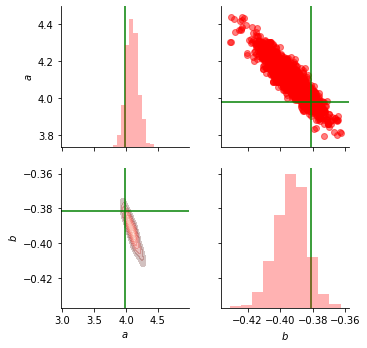

In [43]:
tri=sns.PairGrid(pd.DataFrame(np.vstack((fit_samp['a'],fit_samp['b'])).T,columns=[r'$a$',r'$b$']))
tri.map_diag(plt.hist,alpha=0.3,color='red')
tri.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
tri.map_upper(plt.scatter,alpha=0.5,color='red')

#g.axes[0,1].set_axis_off()
tri.axes[0,0].axvline(x=fit['a'][s],color='g')
tri.axes[1,0].axvline(x=fit['a'][s],color='g')
tri.axes[1,0].axhline(y=fit['b'][s],color='g')
tri.axes[1,1].axvline(x=fit['b'][s],color='g')
tri.axes[0,1].axvline(x=fit['b'][s],color='g')
tri.axes[0,1].axhline(y=fit['a'][s],color='g')

#tri.data=(pd.DataFrame(np.vstack((fit['a'],fit['b'])).T,columns=[r'$\alpha$',r'$\beta$']))
#tri.map_diag(plt.hist,color='blue',alpha=0.1)
#tri.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Blues_d",alpha=0.3,n_levels=10,normed=True)
#tri.map_upper(plt.scatter,alpha=0.5,color='blue')

tri.axes[1,0].set_xlim(fit['a'][s]-1,fit['a'][s]+1)


When analysing posterior probability distributions for model parameters, it is good practise to do so alongside the prior distribution. This allows us to visualise whether we are gaining much information from the data, beyond our prior knowledge.

Lets plot replicated data from our model fit, and compare to fitted data

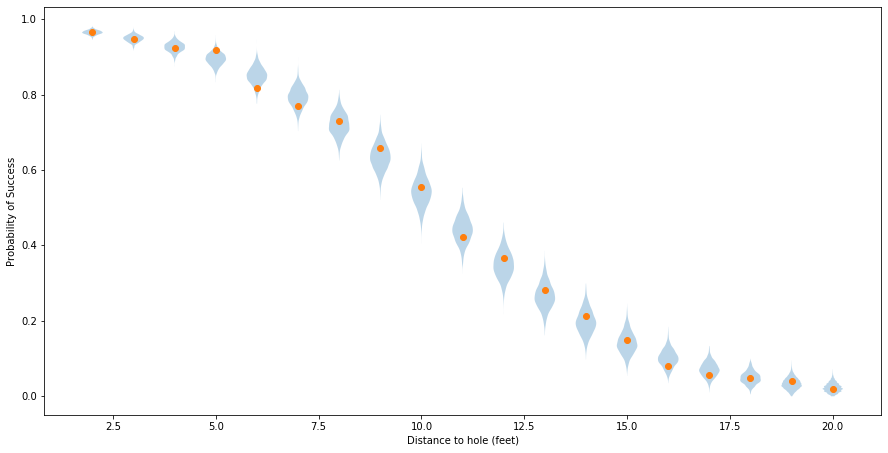

In [44]:
plt.figure(figsize=(15,7.5))
plt.violinplot(fit_samp['y_pred']/data['n'].values,positions=data['x'],showextrema=False);
plt.plot(data['x'],fit['y_pred'][s,:]/data['n'],'o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

### Evaluate Prior-Posterior Consistency

We have fitted one sample. To be confident our chosen fitting algorithm works for all possible values (i.e. within Prior) we should fit *many* samples

 To check the model and our inference technique (i.e. the algorithm used to fit the data) is perfoming appropriately, you can carry out simulated-based calibration. This involved fitting each prior sample as if it were data. The posterior distributions on the fits should look like the prior. This approach checks this is correct. If everything is working, the plots below for each parameter should be uniform.
 
For details, see [Talts et al. 2018](https://arxiv.org/pdf/1804.06788) and [Michael Betancourt's case study](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#22_computational_faithfulness)


In [45]:
samples=[]
n_samp=100
a_cal=np.empty(n_samp)
b_cal=np.empty(n_samp)
for s in range(0,n_samp):
    #set data to one of the samples
    data_samp={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':fit['y_pred'][s,:].astype('int'),
        'fit':1}
    #fit the data
    fit_tmp=sm.sampling(data=data_samp,chains=4,iter=1000,seed=10,verbose=False)
    #append samples to list
    samples.append(pd.DataFrame(np.vstack((fit_tmp['a'],fit_tmp['b'])).T,columns=['a','b']))
    #carry out calibration statistic
    a_cal[s]=np.sum(fit_tmp['a']<fit['a'][s])
    b_cal[s]=np.sum(fit_tmp['b']<fit['b'][s])
    
samples=pd.concat(samples)

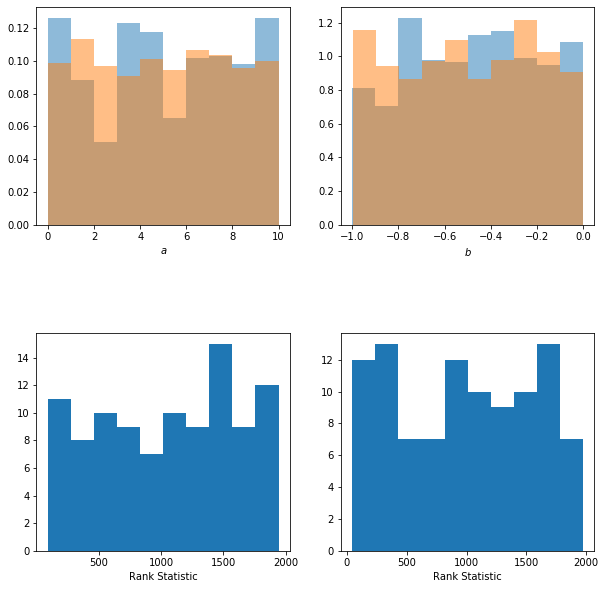

In [46]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(samples['a'],density=True,alpha=0.5,label='Posterior');
plt.hist(fit['a'],density=True,alpha=0.5,label='Prior');
plt.xlabel(r'$a$');
plt.subplot(2,2,2)
plt.hist(samples['b'],density=True,alpha=0.5,label='Posterior');
plt.hist(fit['b'],density=True,alpha=0.5,label='Prior');
plt.xlabel(r'$b$');
plt.subplot(2,2,3)
plt.hist(a_cal)
plt.xlabel('Rank Statistic')
plt.subplot(2,2,4)
plt.hist(b_cal)
plt.xlabel('Rank Statistic')
plt.subplots_adjust(hspace=0.5)

### Analyse Posterior Behaviours

**Z score**
$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

how accurately the posterior recovers ground truth and whether there is any bias. Close to zero indicate more accurate, less biased posteriors.

**Posterior Shrinkage**
$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Close to zero indicates dominated by prior, close to one indicates dominated by data.

Assuming that we are accurately recovering posteriors across all of the simulated observations then we can proceed to analyse the range of behaviors in these posteriors. For example, the posterior z-score of a given parameter,

$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

quantifies how accurately the posterior recovers the ground truth and whether there is any bias. Values close to zero indicate more accurate, less biased posteriors.

At the same time the posterior shrinkage,

$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Our visualisation of the posterior and prior for $\alpha$ and $\beta$ had already indicated that the inference had given us information on both parameters. Shrinkage allows us to quantify this. A value near zero indicates that the data provide little information beyond that encoded in the prior distribution while shrinkage near one indicates highly informative observations.


<img src="../assets/sensitivity.png" alt="Drawing" style="width: 600px;"/>

In [47]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))
n_post_samps=int(len(samples)/n_samp)

z_score_array=np.empty((2,n_samp))
shrinkage_array=np.empty((2,n_samp))
for i in range(0,n_samp):
    z_score_array[0,i]=zscore(samples['a'][i*n_post_samps:(i+1)*n_post_samps],fit['a'][i])
    z_score_array[1,i]=zscore(samples['b'][i*n_post_samps:(i+1)*n_post_samps],fit['b'][i])
    shrinkage_array[0,i]=shrinkage(samples['a'][i*n_post_samps:(i+1)*n_post_samps],fit['a'])
    shrinkage_array[1,i]=shrinkage(samples['b'][i*n_post_samps:(i+1)*n_post_samps],fit['b'])

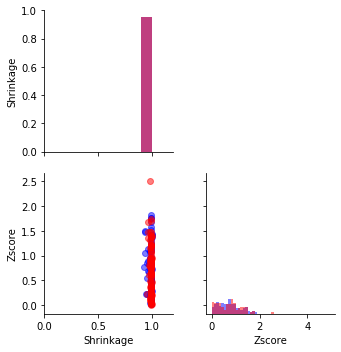

In [48]:
g=sns.PairGrid(pd.DataFrame(np.vstack((shrinkage_array[0,:],z_score_array[0,:])).T,columns=['Shrinkage','Zscore']))
g.map_diag(plt.hist,color='blue',alpha=0.5,bins=np.arange(0,5,0.1))
g.map_lower(plt.scatter,color='blue',alpha=0.5)
g.data=pd.DataFrame(np.vstack((shrinkage_array[1,:],z_score_array[1,:])).T,columns=['Shrinkage','Zscore'])
g.map_diag(plt.hist,color='red',alpha=0.5,bins=np.arange(0,5,0.1))
g.map_lower(plt.scatter,color='red',alpha=0.5)
g.axes[1,0].set_xlim(0,1.2)
g.axes[0,1].set_axis_off()

## Model Inference
Having satisfied ourselves that model is behaving as we expect, lets fit our model to observational data

In [49]:
model_data={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':data['y'],
        'fit':1}

In [50]:
fit_obs=sm.sampling(data=model_data,chains=4,iter=1000,seed=194838)

In [51]:
fit_obs

Inference for Stan model: anon_model_9d53bd31a44b027fe0ac8c6c89a16c2f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            2.23  2.9e-3   0.06   2.12   2.19   2.23   2.27   2.36    422   1.01
b           -0.26  3.4e-4 6.8e-3  -0.27  -0.26  -0.26  -0.25  -0.24    409   1.01
y_pred[1]  1224.0     0.5  16.06 1192.0 1213.0 1224.0 1235.0 1255.0   1050    1.0
y_pred[2]  563.54     0.3  11.35  541.0  556.0  563.0  571.0  585.6   1422    1.0
y_pred[3]   350.3    0.22   9.53  331.0  344.0  350.0  357.0  368.0   1955    1.0
y_pred[4]  255.06    0.21   8.69  237.0  249.0  255.0  261.0  272.0   1707    1.0
y_pred[5]  181.64    0.19    8.2  166.0  176.0  182.0  187.0  197.0   1824    1.0
y_pred[6]  156.01    0.18   7.99  140.0  150.0  156.0  162.0  172.0   1880    1.0
y_pred[7]  131.12    0.17   7.78  116.0  126.0  131.0  137.0  146.0   2012 

### Diagnostic tests

In [52]:
pystan.diagnostics.check_hmc_diagnostics(fit_obs,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.19) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.929) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.12) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.19) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

## Model Checking

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


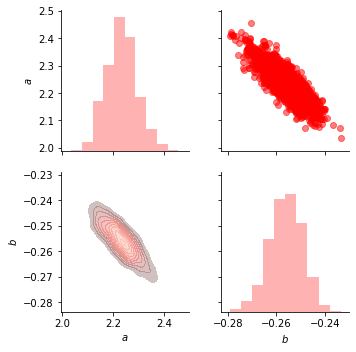

In [53]:
tri=sns.PairGrid(pd.DataFrame(np.vstack((fit_obs['a'],fit_obs['b'])).T,columns=[r'$a$',r'$b$']))
tri.map_diag(plt.hist,alpha=0.3,color='red')
tri.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Reds_d",alpha=0.3,n_levels=10,normed=True)
tri.map_upper(plt.scatter,alpha=0.5,color='red')

#g.axes[0,1].set_axis_off()

#tri.data=(pd.DataFrame(np.vstack((fit['alpha'],fit['beta'])).T,columns=[r'$\alpha$',r'$\beta$']))
#tri.map_diag(plt.hist,color='blue',alpha=0.1)
#tri.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap="Blues_d",alpha=0.3,n_levels=10,normed=True)
#tri.map_upper(plt.scatter,alpha=0.5,color='blue')

#tri.axes[1,0].set_xlim(fit['alpha'][s]-0.3,fit['alpha'][s]+0.3)


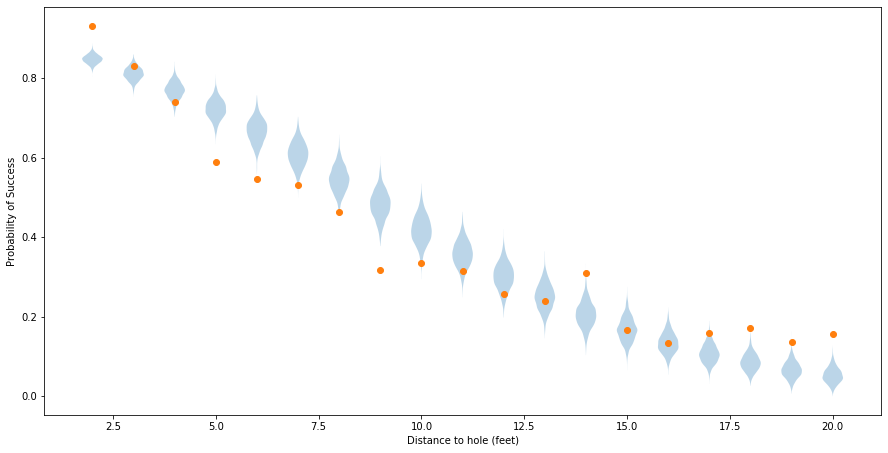

In [54]:
plt.figure(figsize=(15,7.5))
plt.violinplot(fit_obs['y_pred']/data['n'].values,positions=data['x'],showextrema=False);
plt.plot(data['x'],data['y']/data['n'],'o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

### Posterior Predicitive Checks

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


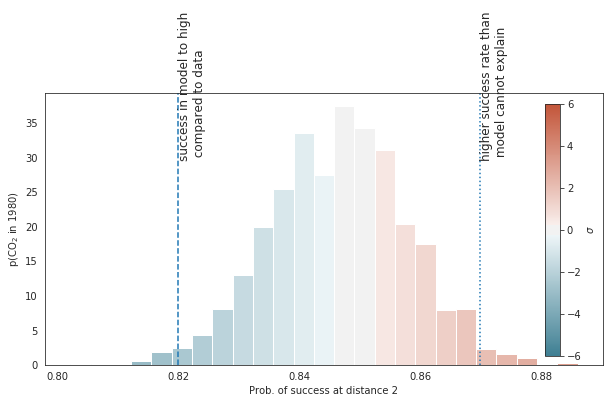

In [61]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(fit_obs['y_pred'][:,0]/data['n'].values[0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(fit_obs['y_pred'][:,0]/data['n'].values[0]))/np.std(fit_obs['y_pred'][:,0]/data['n'].values[0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Prob. of success at distance '+str(data['x'].values[0]))
plt.ylabel('p(CO$_2$ in 1980)')
plt.axvline(0.82, linestyle='--')
plt.axvline(0.87,linestyle=':')
plt.annotate('higher success rate than \n model cannot explain',xy=(0.87, 10),  xycoords='data',
            xytext=(0.87, 30), textcoords='data',rotation='vertical',size='large')
plt.annotate('success in model to high\n compared to data',xy=(0.82, 10),  xycoords='data',
            xytext=(0.82, 30), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real success value. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real success measurement, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ (i.e. near the middle of the distribution) means our model is consistent with the data 
* $0.99$ or $0.01$ (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that  $\sigma < -3$ or $\sigma > 3$ indicates a problem with the model.

For more information on posterior predictive checks, see:
* [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)
* [http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf](http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf)

In [63]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval
pvalues=Bayes_P_value(fit_obs['y_pred']/data['n'].values,data['y']/data['n'])

In [64]:
pvalues

array([        inf,  1.15522085, -1.43250272,        -inf,        -inf,
       -2.5758293 , -2.74778139,        -inf, -2.43237906, -1.39837662,
       -1.37220381, -0.41246313,  3.29052673, -0.08029831, -0.04889873,
        2.03352015,         inf,  2.87816174,         inf])

## Posterior Predictive checks II
The art of posterior predictive checks is to come up with a test statistic that measures what you want your model to be able to capture

Example: The difference in successful putts 

In [65]:
data['y']


0     1346
1      577
2      337
3      208
4      149
5      136
6      111
7       69
8       67
9       75
10      52
11      46
12      54
13      28
14      27
15      31
16      33
17      20
18      24
Name: y, dtype: int64

In [66]:
obs_data_stat=data['y'].values[0]-data['y'].values[-1]

In [67]:
obs_data_stat

1322

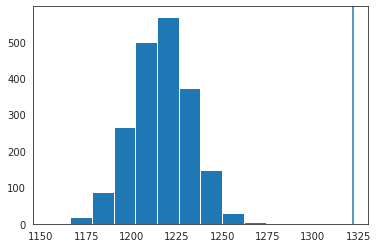

In [68]:
plt.hist(fit_obs['y_pred'][:,0]-fit_obs['y_pred'][:,-1])
plt.axvline(x=obs_data_stat)

In [69]:
ind=(fit_obs['y_pred'][:,0]-fit_obs['y_pred'][:,-1])<obs_data_stat   

In [70]:
import scipy.stats as st
st.norm.ppf(np.sum(ind)/fit_obs['y_pred'].shape[0])

inf

Example of a test statistic:

* Total number of all successfull putts over all distances

In [73]:
obs_success_tot=data['y'].sum()


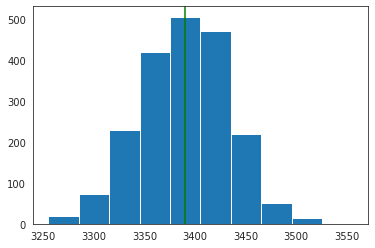

In [81]:
plt.hist(np.sum(fit_obs['y_pred'],axis=1));
plt.axvline(x=obs_success_tot,c='g')

In [82]:
ind=np.sum(fit_obs['y_pred'],axis=1)<obs_success_tot

In [85]:
ind.sum()/2000.0

0.481

In [86]:
st.norm.ppf(ind.sum()/2000.0)

-0.04764395595447656

## Model Improvement
What is wrong with our model?

How could we improve it?